# Overall flow

<img src='https://drive.google.com/uc?id=1z2-t1-VMzjNIJdNQnozMdp1lTlBI5Pt2' width="800"/>


# Model structure and Training flow

<img src='https://drive.google.com/uc?id=1xq5YGrLMtNO4lxMw7sWa2VoQXgDpx-y0' width="800"/>


In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pip install einops

In [3]:
pip install basemap

In [4]:
import os
root_dir = '/content/drive/MyDrive/Colab Notebooks/sst'
%cd /content/drive/MyDrive/Colab Notebooks/sst/
import os
import torch
import argparse
import numpy as np
import copy
import random
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from model import CARE_Net
from diffuzz import Diffuzz, EMA
from sst_dataloader import Dataset
from util import *
import numpy as np
import matplotlib.pyplot as plt
import glob


/content/drive/MyDrive/Colab Notebooks/sst


In [5]:
# Set random seeds
seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [6]:
# Argument parsing
parser = argparse.ArgumentParser(description="SST reconstruction", formatter_class=argparse.ArgumentDefaultsHelpFormatter)
parser.add_argument("--mode", default="mask_reconstruction", choices=["train", "mask_reconstruction", "cloud_reconstruction"], type=str)
parser.add_argument("--train_continue", default="off", choices=["on", "off"], type=str)
parser.add_argument("--lr", default=1e-4, type=float)
parser.add_argument("--batch_size", default=4, type=int)
parser.add_argument("--num_epoch", default=10, type=int)
parser.add_argument("--data_dir", default=root_dir+'/data', type=str)
parser.add_argument("--network", default="CARE_Net", choices=["CARE_Net"], type=str)
args = parser.parse_args([])

In [7]:
# Directory setup
def setup_directories(base_dir, sub_dirs):
    for sub_dir in sub_dirs:
        full_path = os.path.join(base_dir, sub_dir)
        if not os.path.exists(full_path):
            os.makedirs(full_path)

# Denormalization function
def denorm(x, min_val, max_val):
    return ((x + 1) / 2) * (max_val - min_val) + min_val

# Function to save images and numpy arrays
def save_images_and_arrays(id, imgs, oisst_min, oisst_max, prefix=''):
    for key, img in imgs.items():
        plt.imshow(img.squeeze(), vmin=oisst_min, vmax=oisst_max)
        plt.savefig(os.path.join(result_dir, 'png', f'{id:04d}_{prefix}{key}.png'))
        plt.clf()
        np.save(os.path.join(result_dir, 'numpy', f'{id:04d}_{prefix}{key}.npy'), img)

In [8]:
# Directory setup
model_dir = os.path.join(root_dir, 'result')
sub_dirs = ['checkpoint', f'{args.mode}/png', f'{args.mode}/numpy']
setup_directories(model_dir, sub_dirs)
ckpt_dir = os.path.join(model_dir, 'checkpoint')
result_dir = os.path.join(model_dir, args.mode)

In [9]:
# Model setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
netG = CARE_Net().to(device)
# Optimizer and other necessary components
optG = torch.optim.AdamW(netG.parameters(), lr=args.lr)
diffuzz = Diffuzz(device=device)
ema = EMA(0.995)
ema_model = copy.deepcopy(netG).eval().requires_grad_(False)
mse = nn.MSELoss()
_float16_dtype = torch.bfloat16

In [10]:
# DataLoader setup
def get_dataloader(data_dir, mode, batch_size):
    transform = transforms.Compose([])
    viirs_dir = os.path.join(data_dir, 'clear_sky' if mode != 'cloud_reconstruction' else 'cloud', 'viirs')
    oisst_dir = os.path.join(data_dir, 'clear_sky' if mode != 'cloud_reconstruction' else 'cloud', 'oisst')
    dataset = Dataset(viirs_dir=viirs_dir, oisst_dir=oisst_dir, transform=transform, mask_type=mode)
    return DataLoader(dataset, batch_size=batch_size, drop_last=(mode == 'train'), shuffle=(mode == 'train'), num_workers=16, pin_memory=True), len(dataset)

if args.mode == 'train':
    loader_train, _ = get_dataloader(args.data_dir, args.mode, args.batch_size)
else:
    loader_test, num_data_test = get_dataloader(args.data_dir, args.mode, args.batch_size)
    num_batch_test = np.ceil(num_data_test / args.batch_size)

st_epoch = 0

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [11]:
def train_or_reconstruct(args, netG, optG, ema, ema_model, diffuzz, mse, loader, ckpt_dir, result_dir, _float16_dtype=torch.bfloat16):

    if args.mode == 'train':
        if args.train_continue == "on":
            netG, optG, st_epoch = load(ckpt_dir=ckpt_dir, netG=netG, optG=optG)
        else:
            st_epoch = 0

        for epoch in range(st_epoch + 1, args.num_epoch + 1):
            loss_arr = []
            for batch, images in enumerate(loader, 1):
                structure_image = images['structure_image'].to(device)
                gt_image = images['gt_image'].to(device)
                mask = images['inpaint_map'].to(device)
                gt_cloud_mask = images['gt_cloud_mask'].to(device)

                optG.zero_grad()

                with torch.no_grad():
                    t = torch.rand(gt_image.size(0), device=device).mul(1.08).add(0.001).clamp(0.001, 1.0)
                    noised_embeddings, noise = diffuzz.diffuse(gt_image, t)

                with torch.cuda.amp.autocast(dtype=_float16_dtype):
                    pred_noise = netG(torch.cat((noised_embeddings, structure_image), dim=1), t)
                    loss = mse(pred_noise, noise).mean()

                loss.backward()
                optG.step()
                ema.step_ema(ema_model, netG)
                loss_arr.append(loss.item())

                print(f"TRAIN: EPOCH {epoch:04d} / {args.num_epoch:04d} | BATCH {batch:04d} | LOSS {np.mean(loss_arr):.4f}")

            if epoch % 10 == 0:
                save(ckpt_dir=ckpt_dir, netG=netG, optG=optG, ema_model=ema_model, epoch=epoch)
    else:
        netG, optG, st_epoch = load(ckpt_dir=ckpt_dir, netG=netG, optG=optG)

        with torch.no_grad():
            netG.eval()
            for batch, images in enumerate(loader, 1):
                structure_image = images['structure_image'].to(device)
                gt_image = images['gt_image'].to(device)
                mask = images['inpaint_map'].to(device)

                sampled_images_all_steps = diffuzz.sample(
                    model=netG, background=structure_image,
                    shape=gt_image.shape, mask=mask, x_init=gt_image,
                    sampler='ddpm', timesteps=300
                )

                timesteps = [-300, -200, -100, -50, -25, -1]
                sampled_images = [sampled_images_all_steps[step] for step in timesteps]

                ### result saving part###
                for j in range(gt_image.shape[0]):
                    id = args.batch_size * (batch - 1) + j

                    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
                    axes = axes.flatten()

                    for idx, (sampled_images_step, step_name) in enumerate(zip(sampled_images, timesteps)):
                        sampled_image = sampled_images_step[j].squeeze().cpu().numpy()
                        oisst_min = images['oisst_min'][j].cpu().numpy()
                        oisst_max = images['oisst_max'][j].cpu().numpy()
                        land_mask = images['land_mask'][j].cpu().numpy()

                        sampled_image = denorm(sampled_image, oisst_min, oisst_max)
                        sampled_image = np.where(land_mask == 1, np.NaN, sampled_image)

                        ax = axes[idx]
                        im = ax.imshow(sampled_image.squeeze(), vmin=oisst_min, vmax=oisst_max)
                        ax.set_title(f'Timestep {step_name}')

                    fig.subplots_adjust(right=0.85)
                    cbar_ax = fig.add_axes([0.87, 0.15, 0.02, 0.7])
                    fig.colorbar(im, cax=cbar_ax)

                    plt.tight_layout(rect=[0, 0, 0.85, 1])
                    plt.savefig(os.path.join(result_dir, 'png', f'{id:04d}_sampled_images_steps.png'))
                    plt.clf()
                    plt.close(fig)

                    output = sampled_images[-1][j].squeeze().cpu().numpy()
                    gt_img = gt_image[j].squeeze().cpu().numpy()
                    struct_img = structure_image[j, 0].squeeze().cpu().numpy()

                    oisst_min = images['oisst_min'][j].cpu().numpy()
                    oisst_max = images['oisst_max'][j].cpu().numpy()
                    land_mask = images['land_mask'][j].cpu().numpy()
                    gt_cloud_mask = images['gt_cloud_mask'][j].cpu().numpy()
                    inpaint_mask = mask[j].squeeze().cpu().numpy()

                    output = denorm(output, oisst_min, oisst_max)
                    output = np.where(land_mask == 1, np.NaN, output)
                    gt_img = denorm(gt_img, oisst_min, oisst_max)
                    gt_img = np.where(gt_cloud_mask == 1, np.NaN, gt_img)
                    gt_img = np.where(land_mask == 1, np.NaN, gt_img)
                    input_img = np.where(inpaint_mask == 1, np.NaN, gt_img)
                    struct_img = denorm(struct_img, oisst_min, oisst_max)
                    struct_img = np.where(land_mask == 1, np.NaN, struct_img)

                    imgs = {
                        'output_img': output,
                        'gt_img': gt_img,
                        'oisst_img': struct_img,
                        'input_img': input_img
                    }
                    save_images_and_arrays(id, imgs, oisst_min, oisst_max)



# Masked region reconstruction

<img src='https://drive.google.com/uc?id=1BtdAwtwvJaYAUgvpLxybom0Ok3ZzM2pv' width="1000"/>

In [ ]:
args.mode = "mask_reconstruction"

train_or_reconstruct(args, netG, optG, ema, ema_model, diffuzz, mse, loader_test, ckpt_dir, result_dir)

Sampling Progress: 100%|██████████| 300/300 [04:03<00:00,  1.23it/s]
<ipython-input-18-b5a62ff5f2bf>:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])


<Figure size 640x480 with 0 Axes>

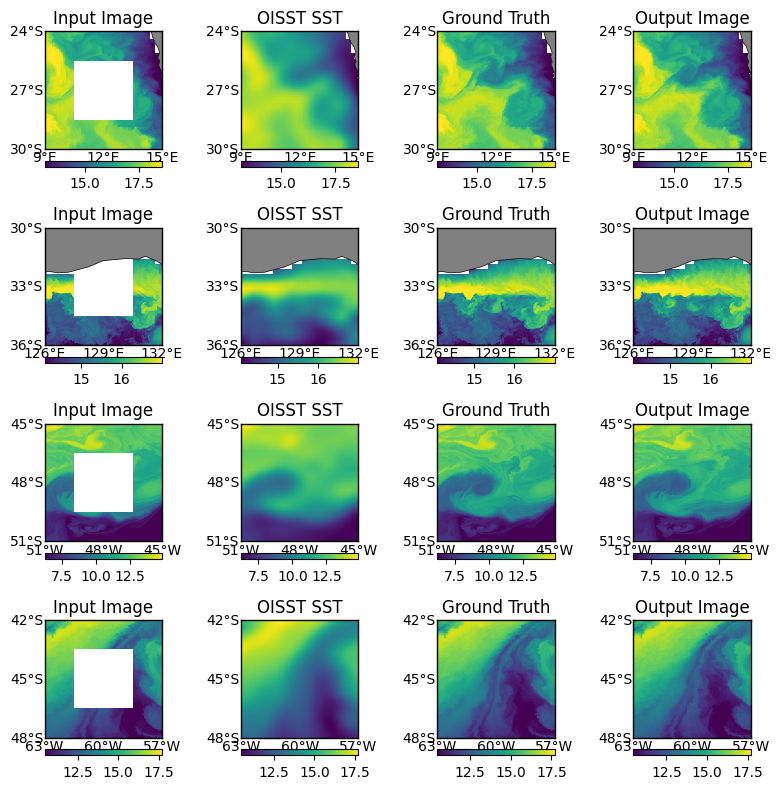

In [ ]:
gt_file_lst = glob.glob(root_dir+'/result/mask_reconstruction/numpy/*_gt_img.npy')
input_file_lst = glob.glob(root_dir+'/result/mask_reconstruction/numpy/*_input_img.npy')
output_file_lst = glob.glob(root_dir+'/result/mask_reconstruction/numpy/*_output_img.npy')
oisst_file_lst = glob.glob(root_dir+'/result/mask_reconstruction/numpy/*_oisst_img.npy')
lonlat_lst = glob.glob(root_dir+'/data/clear_sky/lon_lat/viirs/*.npy')

# Create 4x4 subplot
fig, axes = plt.subplots(4, 4, figsize=(8, 8), dpi=100)
axes = axes.flatten()

# Loop through the indices 0 to 3 and plot the images
for n in range(4):
    output = np.load(output_file_lst[n])
    input_img = np.load(input_file_lst[n])
    gt_img = np.load(gt_file_lst[n])
    oisst_sst = np.load(oisst_file_lst[n])
    lonlat_grid = np.load(lonlat_lst[n])

    a = lonlat_grid[:,:,0].squeeze()
    b = lonlat_grid[:,:,1].squeeze()
    bbox = [round(a.min()), round(b.min()), round(a.max()), round(b.max())]

    # Plot the images in the subplot
    draw_gradient_map(axes[n*4 + 0], input_img.squeeze(), a, b, bbox, np.nanmin(oisst_sst), np.nanmax(oisst_sst), title='Input Image')
    draw_gradient_map(axes[n*4 + 1], oisst_sst.squeeze(), a, b, bbox, np.nanmin(oisst_sst), np.nanmax(oisst_sst), title='OISST SST')
    draw_gradient_map(axes[n*4 + 2], gt_img.squeeze(), a, b, bbox, np.nanmin(oisst_sst), np.nanmax(oisst_sst), title='Ground Truth')
    draw_gradient_map(axes[n*4 + 3], output.squeeze(), a, b, bbox, np.nanmin(oisst_sst), np.nanmax(oisst_sst), title='Output Image')

plt.tight_layout()
plt.show()

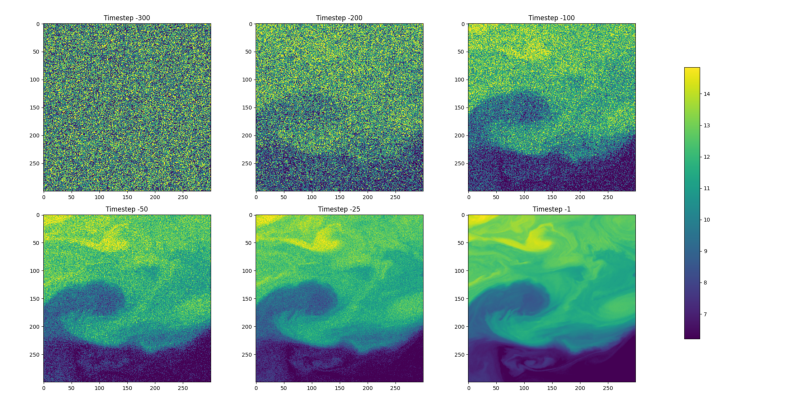

In [12]:
from PIL import Image

# PNG 파일 경로
denoise_step_file_lst = glob.glob('/content/drive/MyDrive/Colab Notebooks/sst/result/mask_reconstruction/png/*_sampled_images_steps.png')

# 이미지 불러오기
image = Image.open(denoise_step_file_lst[2])

# 이미지 시각화
plt.subplots(figsize=(10, 6))
plt.imshow(image)
plt.axis('off')  # 축 숨기기
plt.show()

# Cloud area reconstruction




<img src='https://drive.google.com/uc?id=1rDTsUqi8ld2g6Xk7RquOyJlRTbv6n4u3' width="800"/>

<img src='https://drive.google.com/uc?id=1PGpFM3jnb9B_0YZEJJOpi53mK4kKHg1-' width="500"/>


In [ ]:
args.mode = "cloud_reconstruction"
# Directory setup
model_dir = os.path.join(root_dir, 'result')
sub_dirs = ['checkpoint', f'{args.mode}/png', f'{args.mode}/numpy']
setup_directories(model_dir, sub_dirs)
ckpt_dir = os.path.join(model_dir, 'checkpoint')
result_dir = os.path.join(model_dir, args.mode)

loader_test, num_data_test = get_dataloader(args.data_dir, args.mode, args.batch_size)

train_or_reconstruct(args, netG, optG, ema, ema_model, diffuzz, mse, loader_test, ckpt_dir, result_dir)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Sampling Progress: 100%|██████████| 300/300 [04:03<00:00,  1.23it/s]
<ipython-input-18-b5a62ff5f2bf>:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])
Sampling Progress: 100%|█████████

<Figure size 640x480 with 0 Axes>

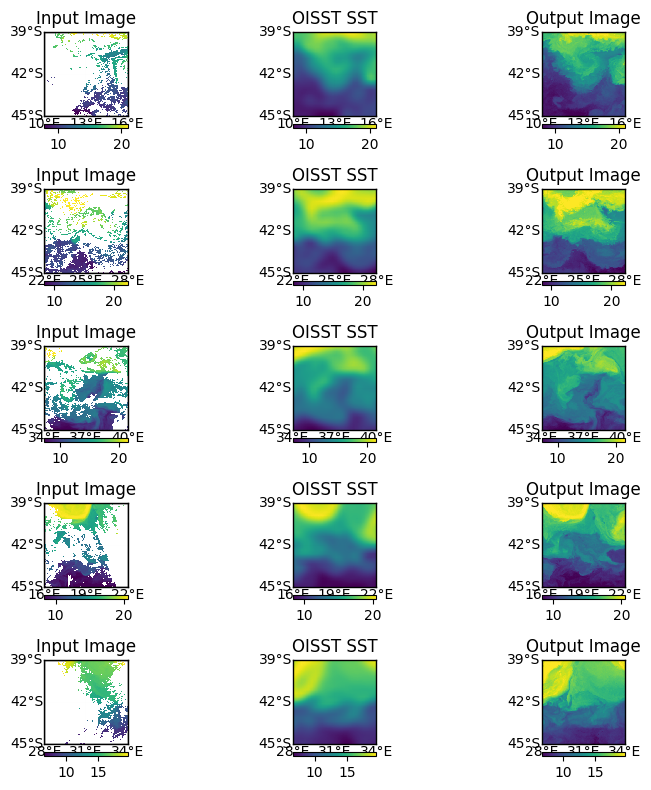

In [14]:
gt_file_lst = glob.glob(root_dir+'/result/cloud_reconstruction/numpy/*_gt_img.npy')
input_file_lst = glob.glob(root_dir+'/result/cloud_reconstruction/numpy/*_input_img.npy')
output_file_lst = glob.glob(root_dir+'/result/cloud_reconstruction/numpy/*_output_img.npy')
oisst_file_lst = glob.glob(root_dir+'/result/cloud_reconstruction/numpy/*_oisst_img.npy')
lonlat_lst = glob.glob(root_dir+'/data/cloud/lon_lat/viirs/*.npy')

# Create 3x3 subplot
fig, axes = plt.subplots(5, 3, figsize=(8, 8), dpi=100)
axes = axes.flatten()

# Loop through the indices 0 to 3 and plot the images
for n in range(5):
    output = np.load(output_file_lst[n])
    input_img = np.load(input_file_lst[n])
    gt_img = np.load(gt_file_lst[n])
    oisst_sst = np.load(oisst_file_lst[n])
    lonlat_grid = np.load(lonlat_lst[n])

    a = lonlat_grid[:,:,0].squeeze()
    b = lonlat_grid[:,:,1].squeeze()
    bbox = [round(a.min()), round(b.min()), round(a.max()), round(b.max())]

    # Plot the images in the subplot
    draw_gradient_map(axes[n*3 + 0], input_img.squeeze(), a, b, bbox, np.nanmin(oisst_sst), np.nanmax(oisst_sst), title='Input Image')
    draw_gradient_map(axes[n*3 + 1], oisst_sst.squeeze(), a, b, bbox, np.nanmin(oisst_sst), np.nanmax(oisst_sst), title='OISST SST')
    draw_gradient_map(axes[n*3 + 2], output.squeeze(), a, b, bbox, np.nanmin(oisst_sst), np.nanmax(oisst_sst), title='Output Image')

plt.tight_layout()
plt.show()

<ipython-input-15-6f86798ecc23>:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])


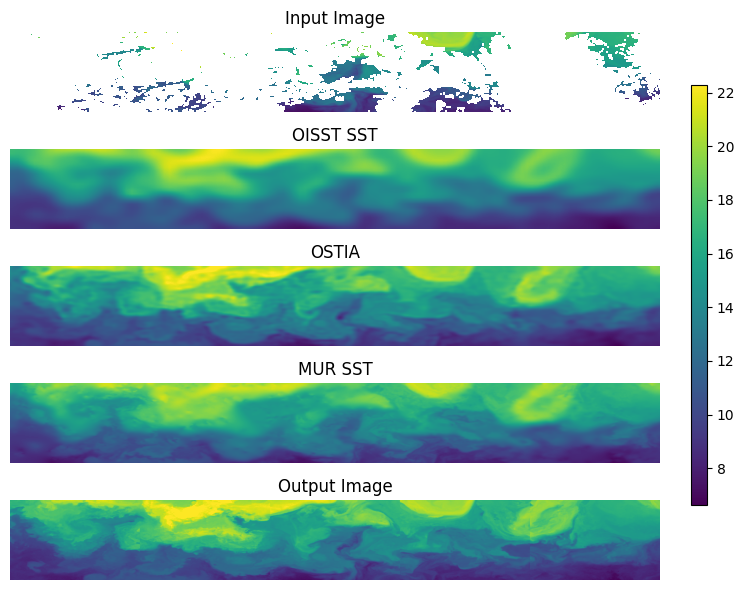

In [15]:
import glob
import numpy as np
import matplotlib.pyplot as plt

gt_file_lst = glob.glob(root_dir+'/result/cloud_reconstruction/numpy/*_gt_img.npy')
input_file_lst = glob.glob(root_dir+'/result/cloud_reconstruction/numpy/*_input_img.npy')
output_file_lst = glob.glob(root_dir+'/result/cloud_reconstruction/numpy/*_output_img.npy')
oisst_file_lst = glob.glob(root_dir+'/result/cloud_reconstruction/numpy/*_oisst_img.npy')

# Load external images
mursst = np.load(root_dir+'/data/cloud/mursst/20220101090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc.npy')[-600:,:,0]
ostia = np.load(root_dir+'/data/cloud/ostia/20220101120000-UKMO-L4_GHRSST-SSTfnd-OSTIA-GLOB-v02.0-fv02.0.nc.npy')[-120:,:,0]

# Concatenate images from file lists
def concatenate_images(file_lst):
    concatenated_image = []
    for file in file_lst:
        img = np.load(file)
        concatenated_image.append(img.squeeze())
    return np.concatenate(concatenated_image, axis=1)

output_concat = concatenate_images(output_file_lst[:5])
input_img_concat = concatenate_images(input_file_lst[:5])
oisst_sst_concat = concatenate_images(oisst_file_lst[:5])

# List of all images to display
images = [input_img_concat, oisst_sst_concat, ostia, mursst, output_concat]
titles = ['Input Image', 'OISST SST', 'OSTIA', 'MUR SST', 'Output Image']

# Determine the min and max values for color scaling based on oisst_sst_concat
vmin = oisst_sst_concat.min()
vmax = oisst_sst_concat.max()

# Plot the images in a single figure
fig, axes = plt.subplots(len(images), 1, figsize=(8, 6), dpi=100)

for ax, img, title in zip(axes, images, titles):
    im = ax.imshow(img, vmin=vmin, vmax=vmax, aspect='auto')
    ax.set_title(title)
    ax.axis('off')

# Add a single colorbar for all images
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()